<a href="https://colab.research.google.com/github/mariasanmartin/analisis_interpretabilidad/blob/main/Codigo_Interpretabilidad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Carga de librerías

In [1]:
import pandas as pd
import seaborn as sn

import matplotlib.pyplot as plt
import os
import numpy as np

import sklearn
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

from sklearn.neural_network import MLPRegressor

from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score, fbeta_score
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.preprocessing import StandardScaler

# Carga y Preprocesamiento de los datos

Carga de los datos (disponibles en github)

In [2]:
url = 'https://raw.githubusercontent.com/mariasanmartin/analisis_interpretabilidad/main/german_credit_data.csv'

df = pd.read_csv(url)
df.head()

#Eliminar la primera variable que es equivalente al indice
df = df.iloc[: , 1:]
df.head()



Age     Sex  Job Housing Saving accounts Checking account  Credit amount  \
0   67    male    2     own             NaN           little           1169   
1   22  female    2     own          little         moderate           5951   
2   49    male    1     own          little              NaN           2096   
3   45    male    2    free          little           little           7882   
4   53    male    2    free          little           little           4870   

   Duration              Purpose  Risk  
0         6             radio/TV  good  
1        48             radio/TV   bad  
2        12            education  good  
3        42  furniture/equipment  good  
4        24                  car   bad

Tratamiento valores faltantes

In [3]:
#Función que calcula los missing values por columna
def missing_values_table(df):
        # Número total de missing values
        mis_val = df.isnull().sum()

        # Porcentaje de missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)

        # Dataframe con los resultados
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

        # Renombrar las columnas
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})

        # Ordenar el dataframe por porcentaje de missing values
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)

        # Informar de los resultados
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")


        return mis_val_table_ren_columns

#Información de los missing values del dataframe
missing_values = missing_values_table(df)
missing_values.head(10)

# Eliminar las columnas con más de un 30% de missing values
for columna in missing_values.index:
    if missing_values['% of Total Values'][columna] > 30:
        df = df.drop(columns = columna)

# Para la variable Saving accounts crear una nueva categoría para los missing values
df["Saving accounts"] = df["Saving accounts"].fillna('no_inf')




Your selected dataframe has 10 columns.
There are 2 columns that have missing values.


Comprobación de que todos los datos estén bien detectados

In [4]:
print(df.dtypes)

#guardamos una copia de este df para usarla más adelante
df_inicial = df.copy()

Age                 int64
Sex                object
Job                 int64
Housing            object
Saving accounts    object
Credit amount       int64
Duration            int64
Purpose            object
Risk               object
dtype: object


Estudio de correlaciones

<ipython-input-5-4cd9d1775acb>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


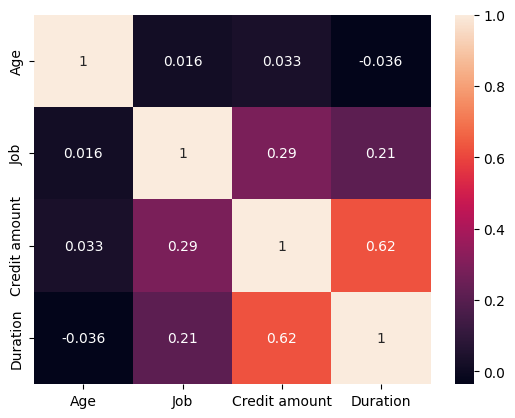

In [5]:
corr_matrix = df.corr()
sn.heatmap(corr_matrix, annot=True)
plt.show()

correlaciones = corr_matrix.abs().unstack().reset_index()
correlaciones = correlaciones[~(correlaciones['level_0'] == correlaciones['level_1'])]


One-Hot encoding variables categóricas

In [6]:
#Identificar variables categóricas
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()

# Convertir columnas categoricas a  dummy variables
dummy_df = pd.get_dummies(df[categorical_columns], drop_first=True)

#Unir las nuevas variables binarias al dataframe original
df = pd.concat([df.drop(columns=categorical_columns), dummy_df], axis=1)



Estudio de correlaciones con las nuevas variables

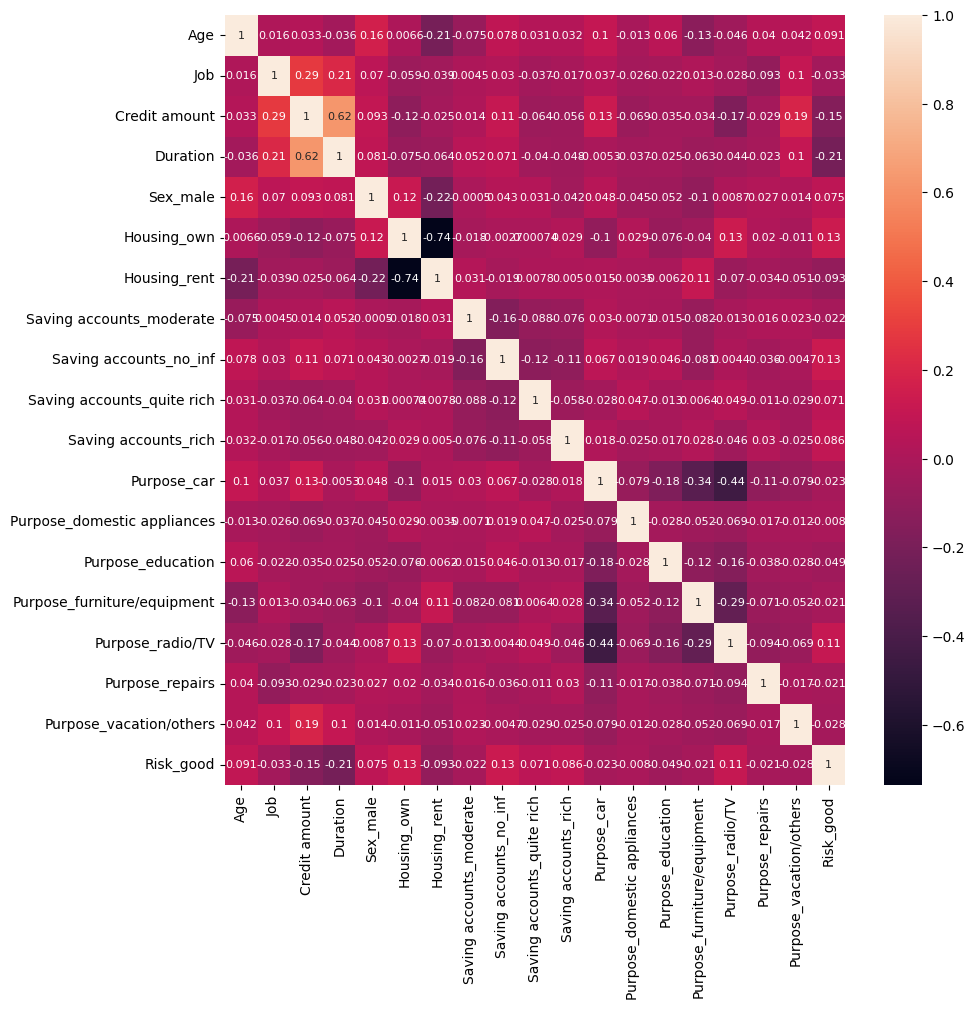

                        level_0                     level_1         0
119                Housing_rent                 Housing_own  0.735968
101                 Housing_own                Housing_rent  0.735968
59                     Duration               Credit amount  0.624984
41                Credit amount                    Duration  0.624984
296            Purpose_radio/TV                 Purpose_car  0.444602
..                          ...                         ...       ...
103                 Housing_own      Saving accounts_no_inf  0.002739
176  Saving accounts_quite rich                 Housing_own  0.000737
104                 Housing_own  Saving accounts_quite rich  0.000737
137    Saving accounts_moderate                    Sex_male  0.000498
83                     Sex_male    Saving accounts_moderate  0.000498

[342 rows x 3 columns]


In [7]:
corr_matrix = df.corr()
ig, ax = plt.subplots(figsize=(10,10))
sn.heatmap(corr_matrix, annot=True, annot_kws={"size": 8}, ax=ax)
plt.show()

correlaciones = corr_matrix.abs().unstack().reset_index()
correlaciones = correlaciones[~(correlaciones['level_0'] == correlaciones['level_1'])].sort_values(by=0, ascending=False)
print(correlaciones)

Separación de datos de entrenamiento y prueba

In [8]:
# Eliminamos la variable target
X = df.drop(columns=df.columns[[-1]],)

#Se escalan los datos


scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
y = df[df.columns[-1]]

# Separacion del train y el test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=123)


# Entrenamiento del modelo

Entrenamiento de la red neuronal

In [9]:
mlp = MLPClassifier(hidden_layer_sizes=(17,8), activation='relu', solver='lbfgs', max_iter=100, random_state=123)
mlp.fit(X_train,y_train)
score = mlp.score(X_test, y_test)
print("Accuracy:", score)
y_pred = mlp.predict(X_test)
nn_cm =confusion_matrix(y_test,y_pred)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test, y_pred))



Accuracy: 0.7433333333333333
[[ 56  44]
 [ 33 167]]
              precision    recall  f1-score   support

           0       0.63      0.56      0.59       100
           1       0.79      0.83      0.81       200

    accuracy                           0.74       300
   macro avg       0.71      0.70      0.70       300
weighted avg       0.74      0.74      0.74       300



/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [10]:

# Add the predicted values as a new column to your DataFrame
df_with_predictions = X_test.copy()
df_with_predictions['Actual'] = y_test
df_with_predictions['Predicted'] = y_pred
random_variables = df_with_predictions.sample(n=3, random_state=123)
print(random_variables)

index_selected = random_variables.index.tolist()
print(index_selected)

          Age       Job  Credit amount  Duration  Sex_male  Housing_own  \
801  1.095360 -1.383771      -0.523250 -0.240857 -1.491914    -1.576173   
313 -0.927547 -1.383771      -0.916682 -0.738668  0.670280     0.634448   
485  1.007407  1.677670      -0.730954 -1.236478  0.670280     0.634448   

     Housing_rent  Saving accounts_moderate  Saving accounts_no_inf  \
801      2.141633                 -0.338862               -0.473276   
313     -0.466933                 -0.338862               -0.473276   
485     -0.466933                 -0.338862               -0.473276   

     Saving accounts_quite rich  Saving accounts_rich  Purpose_car  \
801                   -0.259299             -0.224544    -0.712949   
313                   -0.259299             -0.224544     1.402626   
485                   -0.259299             -0.224544     1.402626   

     Purpose_domestic appliances  Purpose_education  \
801                    -0.110208          -0.250398   
313                    

In [ ]:

observaciones = df_inicial.loc[index_selected]
observaciones = observaciones.sort_index()
print(observaciones)
index_selected = observaciones.index.tolist()

     Age     Sex  Job Housing Saving accounts  Credit amount  Duration  \
313   25    male    1     own          little            685        12   
485   47    male    3     own          little           1209         6   
801   48  female    1    rent          little           1795        18   

      Purpose  Risk  
313       car   bad  
485       car   bad  
801  radio/TV  good  


#  Análisis de interpretabilidad

## LIME

In [ ]:
X_restored = pd.DataFrame(scaler.inverse_transform(X_train), columns=X.columns)


In [ ]:
!pip install lime
import lime
from lime import lime_tabular

explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns,
    class_names=[0, 1],
    mode='classification'
)
lime_exps = pd.DataFrame()
for id in index_selected:
  print(id)
  exp = explainer.explain_instance(
      data_row=X_test.loc[id],
      predict_fn=mlp.predict_proba
  )

  exp.show_in_notebook(show_table=True)
  explanation_list = exp.as_list()



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
313


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


485


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


801


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


## SHAP


In [ ]:
!pip install shap
import shap
for id in index_selected:
  shap.initjs()
  explainer = shap.KernelExplainer(mlp.predict_proba, X_train)
  shap_values = explainer.shap_values(X_test.loc[id,:])
  shap.force_plot(explainer.expected_value[0], shap_values[0], X_test.loc[id,:])


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names


X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names


X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names


In [ ]:
shap.initjs()
explainer = shap.KernelExplainer(mlp.predict_proba, X_train)
shap_values = explainer.shap_values(X_test.loc[313,:])
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test.loc[313,:])


X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names


In [ ]:
shap.initjs()
explainer = shap.KernelExplainer(mlp.predict_proba, X_train)
shap_values = explainer.shap_values(X_test.loc[485,:])
print(shap_values)
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test.loc[485,:])

X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names


[array([-0.02428364,  0.02011728,  0.        , -0.06431302,  0.00827158,
       -0.06069116,  0.00956166,  0.00377446,  0.02475616,  0.01367658,
        0.00251341, -0.12595624,  0.00538035,  0.        , -0.02312265,
       -0.08598641,  0.0031469 ,  0.00649247]), array([ 0.02428364, -0.02011728,  0.        ,  0.06431302, -0.00827158,
        0.06069116, -0.00956166, -0.00377446, -0.02475616, -0.01367658,
       -0.00251341,  0.12595624, -0.00538035,  0.        ,  0.02312265,
        0.08598641, -0.0031469 , -0.00649247])]


In [ ]:
shap.initjs()
explainer = shap.KernelExplainer(mlp.predict_proba, X_train)
shap_values = explainer.shap_values(X_test.loc[801,:])
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test.loc[801,:])


X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names


# Explicaciones Contrafácticas

In [ ]:
train_counterfactuals =  X_train.merge(y_train, left_index=True, right_index=True)
test_counterfactuals = X_test.merge(y_test, left_index=True, right_index=True)

In [ ]:
!pip install dice_ml
import dice_ml
from dice_ml.utils import helpers  # helper functions

d = dice_ml.Data(dataframe=train_counterfactuals, continuous_features=['Age','Credit amount', 'Duration' ], outcome_name='Risk_good')

# Use one of the supported backends (e.g., sklearn)
m = dice_ml.Model(model=mlp, backend="sklearn")
exp = dice_ml.Dice(d, m)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Encontrar el número de fila en el test dataframe
index_value = 313
row_number = X_test.index.get_loc(index_value)


query_instance = test_counterfactuals.drop(columns="Risk_good")[row_number:row_number+1]

dice_exp = exp.generate_counterfactuals(query_instance, total_CFs=4, desired_class="opposite")
# Visualize counterfactual explanation
dice_exp.visualize_as_dataframe()

100%|██████████| 1/1 [00:00<00:00,  5.18it/s]

Query instance (original outcome : 0)


Age                  Job  Credit amount  Duration            Sex_male  \
0 -0.927547  -1.3837714491773996      -0.916682 -0.738668  0.6702800625998365   

          Housing_own          Housing_rent Saving accounts_moderate  \
0  0.6344482202508911  -0.46693339630992875      -0.3388616263074406   

  Saving accounts_no_inf Saving accounts_quite rich  Saving accounts_rich  \
0   -0.47327603792959494       -0.25929878350055285  -0.22454435656953595   

          Purpose_car Purpose_domestic appliances    Purpose_education  \
0  1.4026257699205102        -0.11020775375559674  -0.2503981951023624   

  Purpose_furniture/equipment     Purpose_radio/TV       Purpose_repairs  \
0        -0.47010766958349126  -0.6236095644623236  -0.14998295745037957   

  Purpose_vacation/others  Risk_good  
0    -0.11020775375559674          0


Diverse Counterfactual set (new outcome: 1.0)


Age                Job  Credit amount  Duration Sex_male Housing_own  \
0 -0.927547  1.677669810064635      -0.621929 -0.738668  0.67028    0.634448   
1 -0.927547          -1.383771      -0.916682 -0.738668  0.67028    0.634448   
2  2.137035          -1.383771      -0.916682 -0.738668  0.67028    0.634448   
3 -0.927547          -1.383771      -0.916682 -0.738668  0.67028    0.634448   

  Housing_rent Saving accounts_moderate Saving accounts_no_inf  \
0    -0.466933                -0.338862              -0.473276   
1    -0.466933                -0.338862              -0.473276   
2    -0.466933                -0.338862              -0.473276   
3    -0.466933                -0.338862              -0.473276   

  Saving accounts_quite rich Saving accounts_rich Purpose_car  \
0                  -0.259299            -0.224544    1.402626   
1                  -0.259299            -0.224544    1.402626   
2                  -0.259299            -0.224544    1.402626   
3                  -0.259299            -0.224544    1.402626   

  Purpose_domestic appliances Purpose_education Purpose_furniture/equipment  \
0                   -0.110208         -0.250398                   -0.470108   
1                   -0.110208         -0.250398                   -0.470108   
2        -0.11020775375559674         -0.250398                   -0.470108   
3                   -0.110208         -0.250398                   -0.470108   

      Purpose_radio/TV Purpose_repairs Purpose_vacation/others  Risk_good  
0             -0.62361       -0.149983               -0.110208          1  
1             -0.62361       -0.149983       9.073771725877465          1  
2             -0.62361       -0.149983               -0.110208          1  
3  -0.6236095644623236       -0.149983       9.073771725877465          1

In [ ]:
# Encontrar el número de fila en el test dataframe
index_value = 485
row_number = X_test.index.get_loc(index_value)

query_instance = test_counterfactuals.drop(columns="Risk_good")[row_number:row_number+1]

dice_exp = exp.generate_counterfactuals(query_instance, total_CFs=4, desired_class="opposite")
# Visualize counterfactual explanation
dice_exp.visualize_as_dataframe()

100%|██████████| 1/1 [02:28<00:00, 148.32s/it]

Query instance (original outcome : 1)


Age                Job  Credit amount  Duration            Sex_male  \
0  1.007407  1.677669810064635      -0.730954 -1.236478  0.6702800625998365   

          Housing_own          Housing_rent Saving accounts_moderate  \
0  0.6344482202508911  -0.46693339630992875      -0.3388616263074406   

  Saving accounts_no_inf Saving accounts_quite rich  Saving accounts_rich  \
0   -0.47327603792959494       -0.25929878350055285  -0.22454435656953595   

          Purpose_car Purpose_domestic appliances    Purpose_education  \
0  1.4026257699205102        -0.11020775375559674  -0.2503981951023624   

  Purpose_furniture/equipment     Purpose_radio/TV       Purpose_repairs  \
0        -0.47010766958349126  -0.6236095644623236  -0.14998295745037957   

  Purpose_vacation/others  Risk_good  
0    -0.11020775375559674          1


Diverse Counterfactual set (new outcome: 0.0)


Age      Job  Credit amount  Duration            Sex_male Housing_own  \
0  1.008407  1.67767      -0.730954 -1.236478  0.6702800625998365    0.634448   
1  1.008407  1.67767       2.398245 -1.236478             0.67028    0.634448   
2  1.008407  1.67767      -0.730954 -1.236478             0.67028    0.634448   
3  1.008407  1.67767      -0.730954 -1.236478             0.67028    0.634448   

  Housing_rent Saving accounts_moderate Saving accounts_no_inf  \
0    -0.466933                -0.338862              -0.473276   
1    -0.466933                -0.338862              -0.473276   
2    -0.466933                -0.338862              -0.473276   
3    -0.466933                -0.338862              -0.473276   

  Saving accounts_quite rich Saving accounts_rich          Purpose_car  \
0                  -0.259299            -0.224544             1.402626   
1                  -0.259299            -0.224544             1.402626   
2                  -0.259299            -0.224544  -0.7129485436850859   
3                  -0.259299            -0.224544  -0.7129485436850859   

  Purpose_domestic appliances Purpose_education Purpose_furniture/equipment  \
0                   -0.110208         -0.250398                   -0.470108   
1                   -0.110208         -0.250398                   -0.470108   
2                   -0.110208         -0.250398                   -0.470108   
3                   -0.110208         -0.250398                   -0.470108   

     Purpose_radio/TV Purpose_repairs Purpose_vacation/others  Risk_good  
0  1.6035674514745464       -0.149983               -0.110208          0  
1            -0.62361       -0.149983               -0.110208          0  
2            -0.62361       -0.149983       9.073771725877465          0  
3            -0.62361       -0.149983    -0.11020775375559674          0

In [ ]:
# Encontrar el número de fila en el test dataframe
index_value = 801
row_number = X_test.index.get_loc(index_value)

query_instance = test_counterfactuals.drop(columns="Risk_good")[row_number:row_number+1]

dice_exp = exp.generate_counterfactuals(query_instance, total_CFs=4, desired_class="opposite")
# Visualize counterfactual explanation
dice_exp.visualize_as_dataframe()

100%|██████████| 1/1 [01:47<00:00, 107.69s/it]

Query instance (original outcome : 1)


Age                  Job  Credit amount  Duration             Sex_male  \
0  1.09536  -1.3837714491773996       -0.52325 -0.240857  -1.4919136877222166   

           Housing_own        Housing_rent Saving accounts_moderate  \
0  -1.5761727562330499  2.1416330635220753      -0.3388616263074406   

  Saving accounts_no_inf Saving accounts_quite rich  Saving accounts_rich  \
0   -0.47327603792959494       -0.25929878350055285  -0.22454435656953595   

           Purpose_car Purpose_domestic appliances    Purpose_education  \
0  -0.7129485436850859        -0.11020775375559674  -0.2503981951023624   

  Purpose_furniture/equipment    Purpose_radio/TV       Purpose_repairs  \
0        -0.47010766958349126  1.6035674514745464  -0.14998295745037957   

  Purpose_vacation/others  Risk_good  
0    -0.11020775375559674          1


Diverse Counterfactual set (new outcome: 0.0)


Age       Job  Credit amount  Duration            Sex_male  \
0 -0.761557 -1.383771       -0.52325 -0.240857           -1.491914   
1  1.096360 -1.383771       -0.52325 -0.240857           -1.491914   
2  1.096360 -1.383771       -0.52325 -0.240857           -1.491914   
3  1.000000 -1.383771       -0.52325 -0.240857  0.6702800625998365   

          Housing_own Housing_rent Saving accounts_moderate  \
0           -1.576173     2.141633                -0.338862   
1  0.6344482202508911     2.141633                -0.338862   
2           -1.576173     2.141633                -0.338862   
3           -1.576173     2.141633                -0.338862   

  Saving accounts_no_inf Saving accounts_quite rich Saving accounts_rich  \
0              -0.473276                  -0.259299            -0.224544   
1              -0.473276          3.856554922857429            -0.224544   
2              -0.473276                  -0.259299    4.453463071962463   
3              -0.473276                  -0.259299            -0.224544   

           Purpose_car Purpose_domestic appliances Purpose_education  \
0            -0.712949                   -0.110208         -0.250398   
1            -0.712949                   -0.110208         -0.250398   
2            -0.712949                   -0.110208         -0.250398   
3  -0.7129485436850859                   -0.110208         -0.250398   

  Purpose_furniture/equipment Purpose_radio/TV    Purpose_repairs  \
0                   -0.470108         1.603567          -0.149983   
1                   -0.470108         1.603567          -0.149983   
2                   -0.470108         1.603567  6.667424199385056   
3                   -0.470108         1.603567          -0.149983   

  Purpose_vacation/others  Risk_good  
0               -0.110208          0  
1               -0.110208          0  
2               -0.110208          0  
3               -0.110208          0

## Anchors

In [ ]:
!pip install anchor-exp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
from anchor import anchor_tabular
features = X_train.columns.tolist()
features = np.array(features)

classes = [0,1]
classes = np.array(classes)
print(features)
explainer = anchor_tabular.AnchorTabularExplainer(class_names=classes,
                                                  feature_names=features,
                                                  train_data=X_train.values)

['Age' 'Job' 'Credit amount' 'Duration' 'Sex_male' 'Housing_own'
 'Housing_rent' 'Saving accounts_moderate' 'Saving accounts_no_inf'
 'Saving accounts_quite rich' 'Saving accounts_rich' 'Purpose_car'
 'Purpose_domestic appliances' 'Purpose_education'
 'Purpose_furniture/equipment' 'Purpose_radio/TV' 'Purpose_repairs'
 'Purpose_vacation/others']


In [ ]:
import warnings
warnings.filterwarnings("ignore")
idx = 313
X_test_select = X_test.loc[idx,:]

X_test_select = X_test_select.to_numpy()
exp = explainer.explain_instance(X_test_select, mlp.predict, threshold=0.80)

warnings.filterwarnings("default")

In [ ]:
print('Anchor: %s' % (' AND '.join(exp.names())))


print("\n".join(exp.names()))
print("\n")
print('Precision: %.2f' % exp.precision())
print('Coverage: %.2f' % exp.coverage())

Anchor: Purpose_car > -0.71 AND Age <= -0.75 AND Saving accounts_no_inf <= -0.47 AND Housing_own > -1.58 AND Purpose_repairs <= -0.15 AND Purpose_education <= -0.25 AND Saving accounts_rich <= -0.22 AND Job <= 0.15 AND Purpose_furniture/equipment <= -0.47 AND Saving accounts_moderate <= -0.34 AND Housing_rent <= -0.47 AND Purpose_domestic appliances <= -0.11 AND Saving accounts_quite rich <= -0.26
Purpose_car > -0.71
Age <= -0.75
Saving accounts_no_inf <= -0.47
Housing_own > -1.58
Purpose_repairs <= -0.15
Purpose_education <= -0.25
Saving accounts_rich <= -0.22
Job <= 0.15
Purpose_furniture/equipment <= -0.47
Saving accounts_moderate <= -0.34
Housing_rent <= -0.47
Purpose_domestic appliances <= -0.11
Saving accounts_quite rich <= -0.26


Precision: 0.81
Coverage: 0.02


`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [ ]:
warnings.filterwarnings("ignore")
idx = 485
X_test_select = X_test.loc[idx,:]

X_test_select = X_test_select.to_numpy()
exp = explainer.explain_instance(X_test_select, mlp.predict, threshold=0.80)
warnings.filterwarnings("default")

In [ ]:
print('Anchor: %s' % (' AND '.join(exp.names())))
print('Precision: %.2f' % exp.precision())
print('Coverage: %.2f' % exp.coverage())

Anchor: Duration <= -0.74
Precision: 0.81
Coverage: 0.35


`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [ ]:
warnings.filterwarnings("ignore")
idx = 801
X_test_select = X_test.loc[idx,:]

X_test_select = X_test_select.to_numpy()
exp = explainer.explain_instance(X_test_select, mlp.predict, threshold=0.80)
warnings.filterwarnings("default")

In [ ]:
print('Anchor: %s' % (' AND '.join(exp.names())))
print('Precision: %.2f' % exp.precision())
print('Coverage: %.2f' % exp.coverage())
print(exp.names())
print(type(exp.names()))


print("\n".join(exp.names()))
print("\n")
print('Precision: %.2f' % exp.precision())
print('Coverage: %.2f' % exp.coverage())

Anchor: Duration <= -0.24 AND Purpose_radio/TV > -0.62
Precision: 0.86
Coverage: 0.16
['Duration <= -0.24', 'Purpose_radio/TV > -0.62']
<class 'list'>
Duration <= -0.24
Purpose_radio/TV > -0.62


Precision: 0.86
Coverage: 0.16


`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


## Gráficos de ICE

In [37]:
random_variables = random_variables.iloc[:, :-2]

Age       Job  Credit amount  Duration  Sex_male  Housing_own  \
801  1.095360 -1.383771      -0.523250 -0.240857 -1.491914    -1.576173   
313 -0.927547 -1.383771      -0.916682 -0.738668  0.670280     0.634448   
485  1.007407  1.677670      -0.730954 -1.236478  0.670280     0.634448   

     Housing_rent  Saving accounts_moderate  Saving accounts_no_inf  \
801      2.141633                 -0.338862               -0.473276   
313     -0.466933                 -0.338862               -0.473276   
485     -0.466933                 -0.338862               -0.473276   

     Saving accounts_quite rich  Saving accounts_rich  Purpose_car  \
801                   -0.259299             -0.224544    -0.712949   
313                   -0.259299             -0.224544     1.402626   
485                   -0.259299             -0.224544     1.402626   

     Purpose_domestic appliances  Purpose_education  \
801                    -0.110208          -0.250398   
313                    -0.110208          -0.250398   
485                    -0.110208          -0.250398   

     Purpose_furniture/equipment  Purpose_radio/TV  Purpose_repairs  \
801                    -0.470108          1.603567        -0.149983   
313                    -0.470108         -0.623610        -0.149983   
485                    -0.470108         -0.623610        -0.149983   

     Purpose_vacation/others  
801                -0.110208  
313                -0.110208  
485                -0.110208

In [38]:
#!pip install pycebox
from pycebox.ice import ice, ice_plot
ice_df = ice(random_variables, 'Age', mlp.predict, num_grid_points=100)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/pycebox/ice.py:161: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for color_raw, (_, ice_curve) in zip(colors_raw, plot_ice_data.iteritems()):


Text(0, 0.5, 'Risk_good')

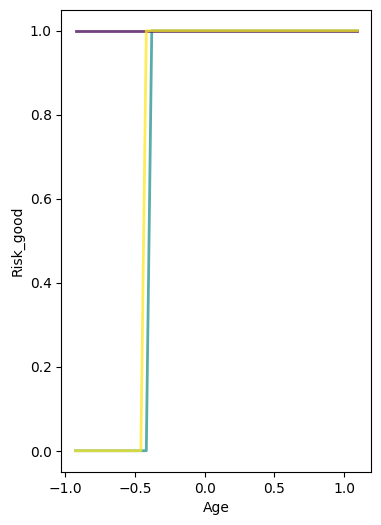

In [39]:
fig, ( ice_ax) = plt.subplots(ncols=1, sharex=True, sharey=True, figsize=(4, 6))
ice_plot(ice_df, frac_to_plot=1,color_by='Duration',
          alpha=0.75, linewidth=2,
         ax=ice_ax)
plt.xlabel("Age")
plt.ylabel("Risk_good")

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pycebox/ice.py:161: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for color_raw, (_, ice_curve) in zip(colors_raw, plot_ice_data.iteritems()):


Text(0, 0.5, 'Risk_good')

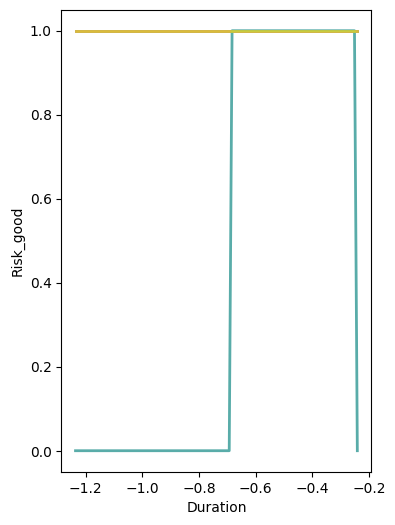

In [40]:
ice_df = ice(random_variables, 'Duration', mlp.predict, num_grid_points=100)
fig, ( ice_ax) = plt.subplots(ncols=1, sharex=True, sharey=True, figsize=(4, 6))
ice_plot(ice_df, frac_to_plot=1,color_by='data_Duration',
          alpha=0.75, linewidth=2,
         ax=ice_ax)
plt.xlabel("Duration")
plt.ylabel("Risk_good")

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pycebox/ice.py:161: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for color_raw, (_, ice_curve) in zip(colors_raw, plot_ice_data.iteritems()):


Text(0, 0.5, 'Risk_good')

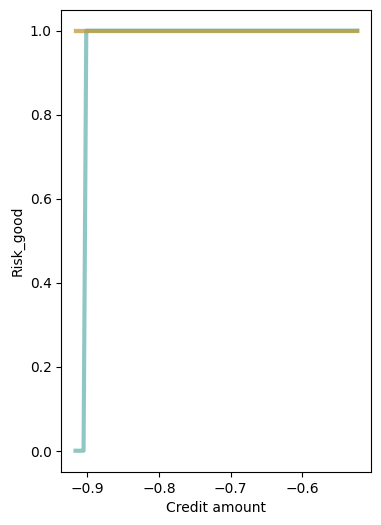

In [41]:
ice_df = ice(random_variables, 'Credit amount', mlp.predict, num_grid_points=100)
fig, ( ice_ax) = plt.subplots(ncols=1, sharex=True, sharey=True, figsize=(4, 6))
ice_plot(ice_df, frac_to_plot=1,color_by='Duration',
          alpha=0.5, linewidth=3,
         ax=ice_ax)
plt.xlabel("Credit amount")
plt.ylabel("Risk_good")